Script for detecting the receptive field of task responding neurons
- First, we detect the neurons involved in the task computing the t-test between activity during the trial vs some ms before sample onset
- Second, from those neurons we compare the fr response against oposit positions (t-test to check significance)
- Third, compute indices for evaluating if visual, memory or motor neuron  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData

from ephysvibe.task import task_constants,def_task
import os 

In [2]:
# load data
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-02-09_10-42-54_Riesling_lip_e1_r1.h5"
s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

In [3]:
# Select trials and create task frame
block = 2
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 6


In [4]:
# Define target codes 
position_codes= {
    # code: [[MonkeyLogic axis], [plot axis]]
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}
# create dict with the trials having each code
target_codes = {}
for i_key,key in enumerate(position_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    target_codes[key]={'code_idx':code_idx,'trial_idx':trials,'position_codes':position_codes[key][1]}

In [5]:
np.where(data.code_numbers[trial_idx] == 'target_on')

/tmp/ipykernel_265757/1632417127.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.where(data.code_numbers[trial_idx] == 'target_on')


(array([], dtype=int64),)

In [6]:
event_align = task_constants.EVENTS_B2['target_on']
target_on = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx] == event_align)[1]]

event_align = task_constants.EVENTS_B2['target_off']
target_off = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx] == event_align)[1]]

event_align = task_constants.EVENTS_B2['fix_spot_off']
fix_spot_off = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx] == event_align)[1]]

event_align = task_constants.EVENTS_B2['eye_in_target']
eye_in_target = data.code_samples[trial_idx, np.where(data.code_numbers[trial_idx][:,:8] == event_align)[1]]

### Neurons responding to the task

In [7]:
# check whether the neuron is responding to the task comparing each epoch with fixation 
codes =  target_codes.keys()
all_e_aling = ['target_on','target_off','fix_spot_off']
all_t_after = [100,500,200]
duration_trial = 2000 # in ms
duration_fix = 500
n_spikes_sec = 5
t_test:Dict[str,list] = defaultdict(list)
i_good,i_mua, n_type = 0,0,0
for i_neuron,type_neuron in enumerate(data.clustersgroup):
    # check and count type of unit
    if type_neuron == 'good':
        i_good+=1
        n_type = i_good
    elif type_neuron == 'mua':
        i_mua+=1
        n_type = i_mua
    
    for e_align, t_after in zip(all_e_aling,all_t_after): # iterate by event
        event_align = task_constants.EVENTS_B2[e_align]
        mean_sp=[]
        for code in codes: # iterate by code
            target_t_idx = target_codes[code]["trial_idx"] # select trials with the same stimulus location
            trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == event_align)[1]] # moment when the event ocurrs in each trial
            shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time).astype(int), axis=1)[:, :t_after] # align trials with event onset
            mean_sp = shift_sp.mean(axis=0) # Average fr of all trials 

            trials_event_time = data.code_samples[ target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
            shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-duration_fix).astype(int), axis=1)[:, :duration_fix] # align trials with (target_on - duration_fix)
            mean_sp_fix = shift_sp.mean(axis=0)# Average fr of all trials 
            
            # check number of spikes, at least 5/sec 
            shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-duration_fix).astype(int), axis=1)[:, :duration_trial]
            if np.any(np.sum(shift_sp,axis=1)>=n_spikes_sec * (duration_trial/1000)): # if at least n_spikes_sec, compute and save t-test in pd.DataFrame
                p=stats.ttest_ind(mean_sp, mean_sp_fix)[1]
                t_test['code']+=[code]
                t_test['cluster']+=[n_type]
                t_test['group']+=[type_neuron]
                t_test['array_position']+=[i_neuron]
                t_test['event']+=[e_align]
                t_test['p']+=[p]
t_test_sacc = pd.DataFrame(t_test)

In [8]:
p_threshold = 0.05
below_threshold = t_test_sacc[t_test_sacc['p']<p_threshold] # results below threshold
significant_units = below_threshold['array_position'].unique()
print('Units showing significant activity: %s'%significant_units)

below_threshold

Units showing significant activity: [0 1 3 4 5]


,code,cluster,group,array_position,event,p
8,121,1,good,0,fix_spot_off,2.823878e-03
12,124,2,good,1,target_on,2.828333e-02
13,123,2,good,1,target_on,7.106805e-03
17,126,2,good,1,target_off,4.088426e-06
19,124,2,good,1,target_off,6.695505e-06
20,123,2,good,1,target_off,9.258162e-10
27,123,2,good,1,fix_spot_off,3.575028e-02
32,124,2,mua,3,target_on,1.737992e-02
33,123,2,mua,3,target_on,1.532705e-02
35,127,2,mua,3,target_off,8.869194e-05


### Detect receptive field

In [9]:
i_neuron

5

In [10]:
below_threshold[below_threshold['array_position']==i_neuron]['code'].values

array(['127', '125', '124', '123', '122', '121', '126', '124'],
      dtype=object)

In [11]:
vm_index_df:Dict[str,list] = defaultdict(list)
for i_neuron in significant_units:
    codes_sig = below_threshold[below_threshold['array_position']==i_neuron]['code'].unique()
    for i_code in codes_sig:
        target_t_idx = target_codes[i_code]["trial_idx"] # select trials with the same stimulus

        # visual response
        trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
        shift_sp_visual = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-50).astype(int), axis=1)[:, :250] # align trials with event onset
        mean_sp_visual = shift_sp_visual.mean(axis=0) # Average fr of all trials  
        # motor response 
        trials_event_time = data.code_samples[target_t_idx, 7] # moment when the target_on ocurrs in each trial #np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['eye_in_target'])[1]
        shift_sp_motor = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-300).astype(int), axis=1)[:, :300] # align trials with event onset
        mean_sp_motor = shift_sp_motor.mean(axis=0) # Average fr of all trials  

        # compute p value
        p= stats.ttest_ind(mean_sp_visual, mean_sp_motor)[1]
        # compute index
        vm_index = (shift_sp_motor.mean()-shift_sp_visual.mean())/(shift_sp_visual.mean()+shift_sp_motor.mean())
        # save results
        vm_index_df['code']+=[i_code]
        vm_index_df['array_position']+=[i_neuron]
        vm_index_df['p']+=[p ]    
        vm_index_df['vm_index']+=[vm_index]  
vm_index_df = pd.DataFrame(vm_index_df)

In [12]:
idx_plot = np.around(vm_index_df[vm_index_df['p']<0.05]['vm_index'].values,1)

In [13]:
data.clustersgroup

array(['good', 'good', 'mua', 'mua', 'good', 'mua'], dtype='<U4')

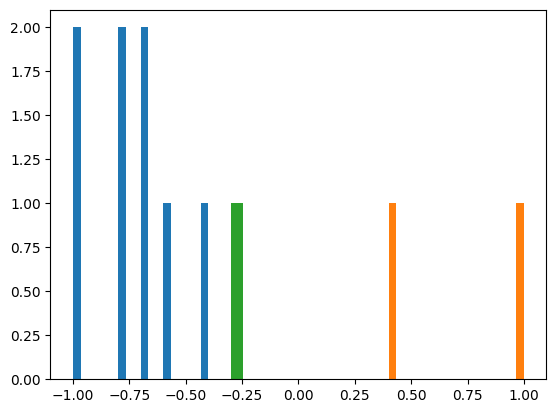

In [14]:
vm_threshold = 0.4
plt.hist(idx_plot[idx_plot<=-vm_threshold],bins=18)
plt.hist(idx_plot[idx_plot>=vm_threshold],bins=18)
a=plt.hist(idx_plot[np.logical_and(idx_plot>-vm_threshold,idx_plot<vm_threshold)],bins=18)

In [15]:
vm_index_df_sig = vm_index_df[vm_index_df['p']<0.05]
vm_index_df_sig

,code,array_position,p,vm_index
1,124,1,5.172661e-03,-0.369369
2,123,1,1.081399e-02,-0.302326
6,127,3,7.860662e-06,-0.655172
7,126,3,6.283728e-07,-1.000000
9,127,4,9.672195e-11,-0.621087
10,126,4,9.515654e-12,-0.720280
11,125,4,1.073750e-07,-0.797571
12,123,4,9.238727e-03,1.000000
13,120,4,1.497701e-07,-0.772727
16,121,4,6.915774e-03,-1.000000


In [16]:
idx = np.around(vm_index_df[vm_index_df['p']<0.05]['vm_index'].values,1)

In [18]:
# search the location where there is the higher activity
left = np.array(['125','124','123','122'])
right = np.array(['121','120','127','126'])
sacc_index = []
rf_t_test:Dict[str,list] = defaultdict(list)
significant_units = vm_index_df_sig['array_position'].unique()

for i_neuron in significant_units:
    i_neuron_df = vm_index_df_sig[vm_index_df_sig['array_position']==i_neuron]
    i_neuron_codes = i_neuron_df['code'].values
    for i_code in i_neuron_codes:
        if i_code in left:
            idx = np.where(left == i_code)[0]
            opposite_code = right[idx][0]
        else:
            idx = np.where(right == i_code)[0]
            opposite_code = left[idx][0]
    
        i_vm_idx = i_neuron_df[i_neuron_df['code']==i_code]['vm_index'].values
        if i_vm_idx <= -vm_threshold: # visuel 
            # i_code
            target_t_idx = target_codes[i_code]["trial_idx"] # select trials with the same stimulus
            trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
            shift_sp_r = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-50).astype(int), axis=1)[:, :250] # align trials with event onset
            mean_sp_code = shift_sp_r.mean(axis=0) # Average fr of all trials  
            # opposite_code
            target_t_idx = target_codes[opposite_code]["trial_idx"] # select trials with the same stimulus
            trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
            shift_sp_l = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-50).astype(int), axis=1)[:, :250] # align trials with event onset
            mean_sp_opposite = shift_sp_l.mean(axis=0) # Average fr of all trials  
            type_neu = 'visual'

        elif i_vm_idx >= vm_threshold: # motor 
            # i_code
            target_t_idx = target_codes[i_code]["trial_idx"] # select trials with the same stimulus
            trials_event_time = data.code_samples[target_t_idx, 7] # moment when the target_on ocurrs in each trial
            shift_sp_r = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-300).astype(int), axis=1)[:, :300] # align trials with event onset
            mean_sp_code = shift_sp_r.mean(axis=0) # Average fr of all trials  
            # opposite_code
            target_t_idx = target_codes[opposite_code]["trial_idx"] # select trials with the same stimulus
            trials_event_time = data.code_samples[target_t_idx, 7] # moment when the target_on ocurrs in each trial
            shift_sp_l = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-300).astype(int), axis=1)[:, :300] # align trials with event onset
            mean_sp_opposite = shift_sp_l.mean(axis=0) # Average fr of all trials  
            type_neu = 'motor'
        else:# i_vm_idx <= -vm_threshold: # visuomotor 
            # i_code
            target_t_idx = target_codes[i_code]["trial_idx"] # select trials with the same stimulus
            trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
            shift_sp_r = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-50).astype(int), axis=1)[:, :1550] # align trials with event onset
            mean_sp_code = shift_sp_r.mean(axis=0) # Average fr of all trials  
            # opposite_code
            target_t_idx = target_codes[opposite_code]["trial_idx"] # select trials with the same stimulus
            trials_event_time = data.code_samples[target_t_idx, np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]] # moment when the target_on ocurrs in each trial
            shift_sp_l = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_event_time-50).astype(int), axis=1)[:, :1550] # align trials with event onset
            mean_sp_opposite = shift_sp_l.mean(axis=0) # Average fr of all trials  
            type_neu = 'visuomotor'

        # check there is at least 1 trial
        p = stats.ttest_ind(mean_sp_code, mean_sp_opposite)[1]

        rf_t_test['code']+=[i_code]
        rf_t_test['array_position']+=[i_neuron]
        rf_t_test['p']+=[p ]  
        rf_t_test['type']+=[type_neu]    
    
rf_t_test = pd.DataFrame(rf_t_test)

In [19]:
rf_t_test[rf_t_test['p']<0.5]

,code,array_position,p,type
0,124,1,4.460858e-04,visuomotor
1,123,1,1.020328e-13,visuomotor
2,127,3,9.150901e-05,visual
3,126,3,7.343062e-02,visual
4,127,4,1.303545e-17,visual
5,126,4,1.745234e-14,visual
6,125,4,8.669760e-03,visual
7,123,4,1.271110e-02,motor
8,120,4,4.521738e-08,visual
9,121,4,8.669760e-03,visual


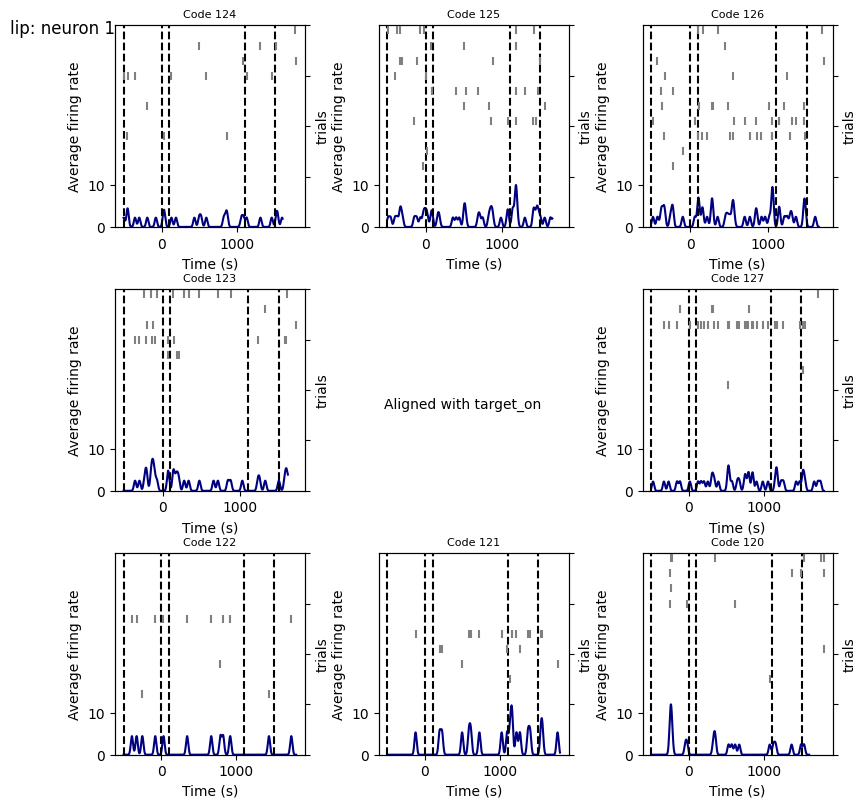

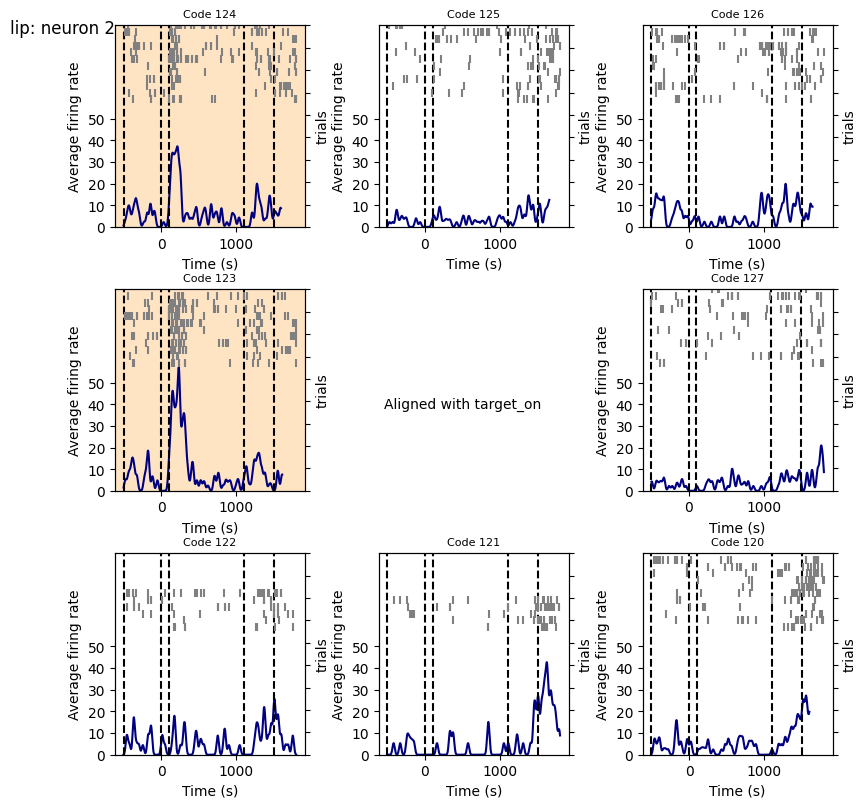

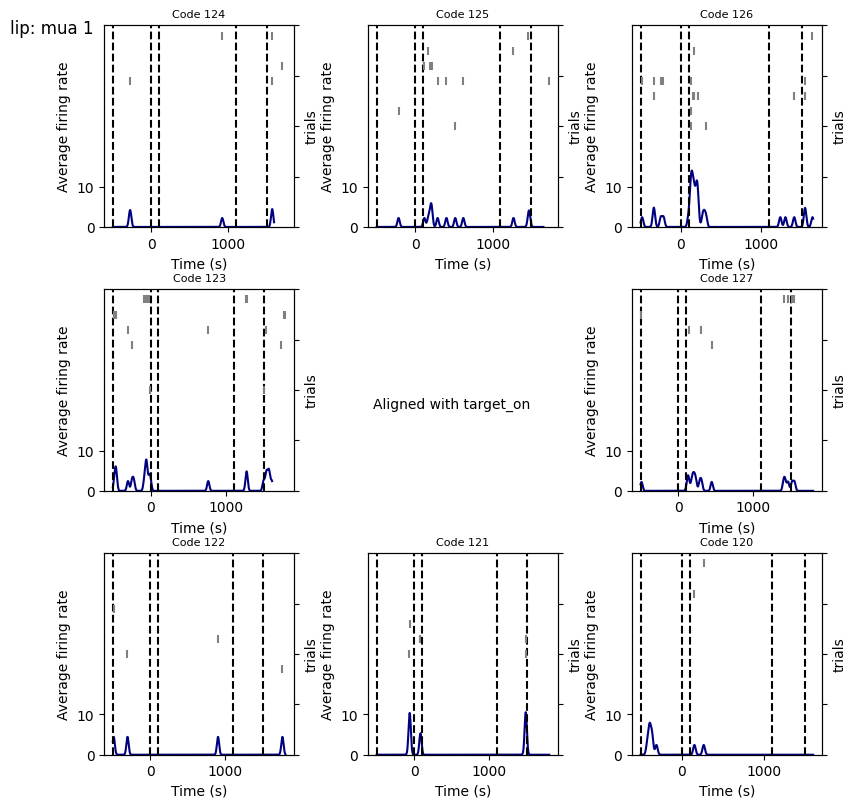

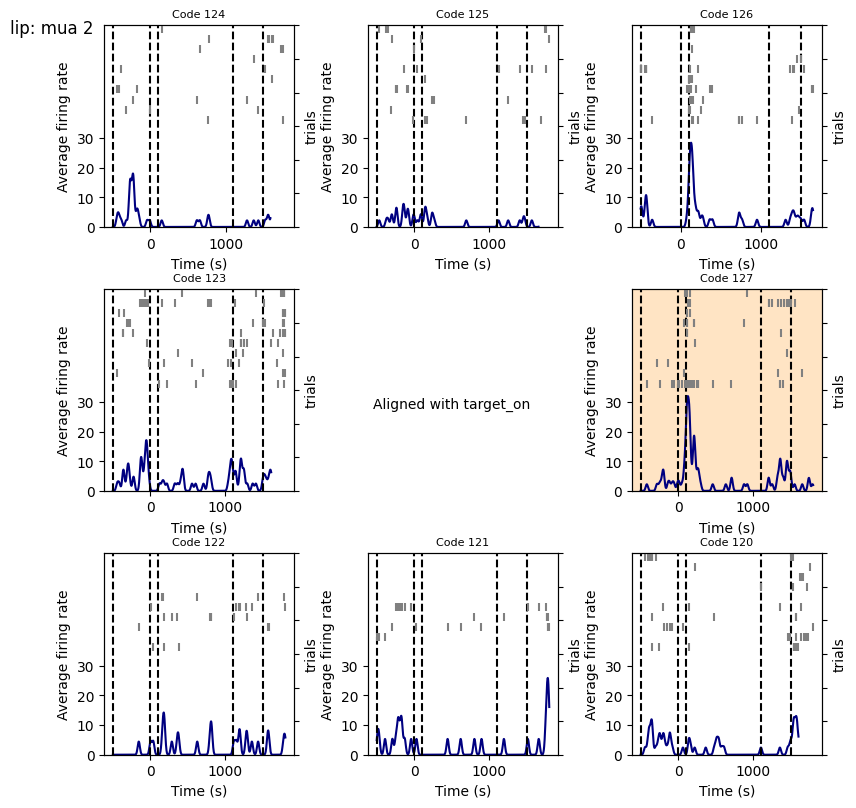

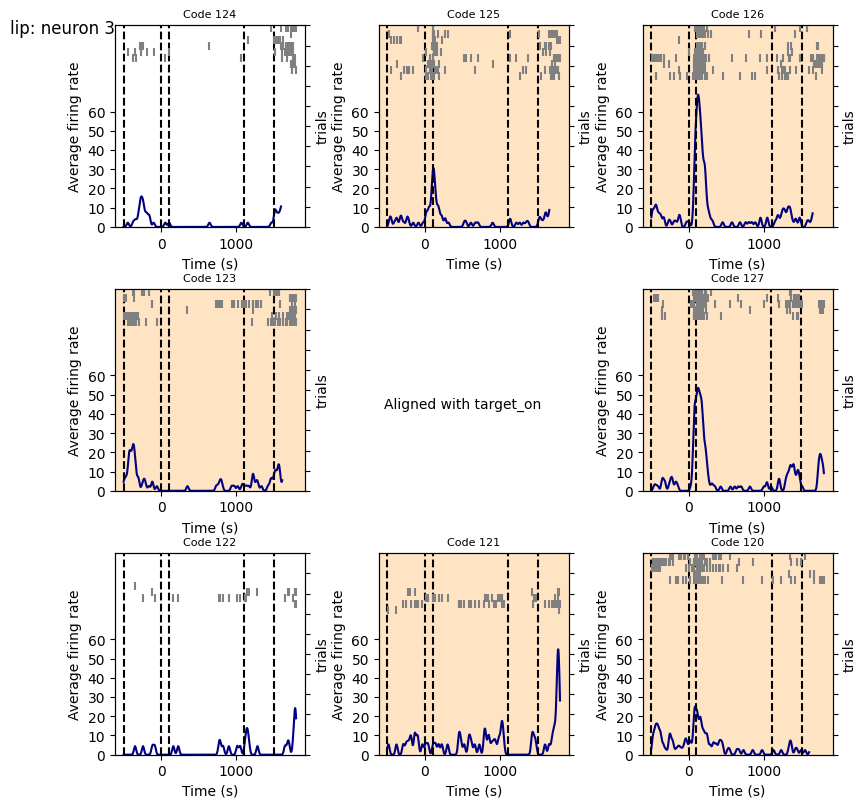

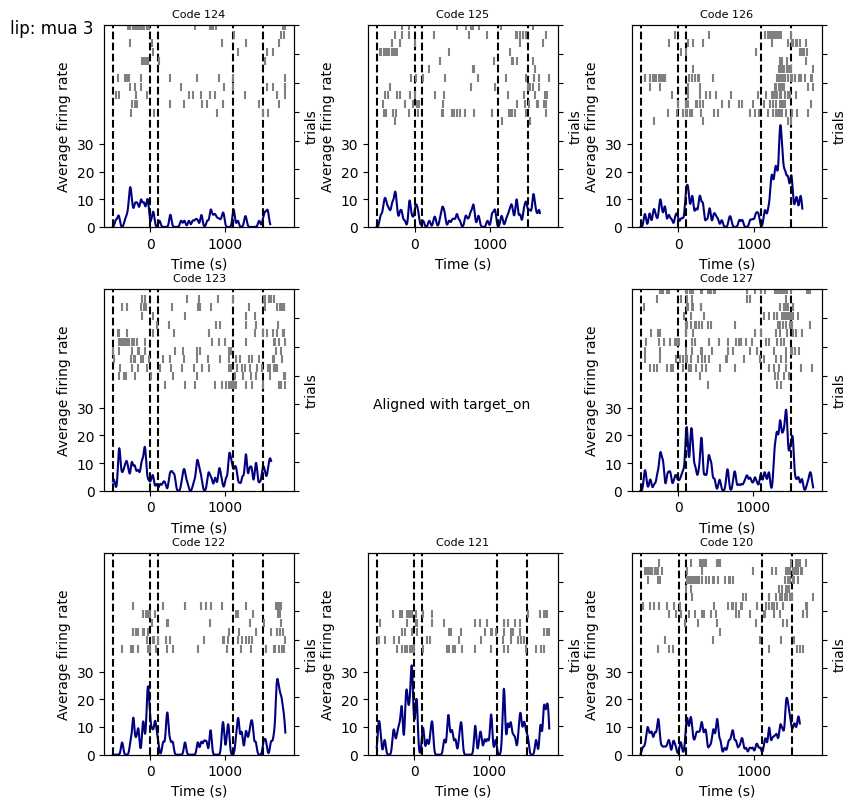

In [20]:
# kernel parameters
t_before=500
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
e_align='target_on'
# select only individual neurons
i_neuron, i_mua = 1, 1
for i_n, cluster in enumerate(data.clustersgroup): # iterate by units
    if cluster == "good":
        i_cluster = i_neuron
        i_neuron += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1

    code_samples=data.code_samples
    code_numbers=data.code_numbers
    sp_samples=data.sp_samples
    e_code_align = task_constants.EVENTS_B2[e_align]
    fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True) # define figure
    all_ax, all_ax2,all_max_conv,max_num_trials=plot_raster.plot_activity_location(target_codes,code_samples,code_numbers,sp_samples, i_n, e_code_align, t_before,fs_ds, kernel,rf_t_test)
    avg_events = [-500, 0, 100,1100,1500]
    num_trials = shift_sp.shape[0]
    for ax, ax2 in zip(all_ax, all_ax2):
        for ev in avg_events:
            ax.vlines(
                ev,
                0,
                all_max_conv + max_num_trials * 3,
                color="k",
                linestyles="dashed",
            )  # target_on
        ax.set_ylim(0, all_max_conv + max_num_trials * 3)
        ax.set_yticks(np.arange(0, all_max_conv, 10))
        ax2.set_ylim(-all_max_conv, max_num_trials)
        ax2.set_yticks(np.arange(-all_max_conv, max_num_trials * 3, 10))
        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        plt.setp(ax2.get_yticklabels(), visible=False)

    fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    fig.suptitle("%s: %s %d" % (s_path[-2], cluster, i_cluster), x=0)
    fig.text(
        0.5,
        0.5,
        s="Aligned with %s" % e_align,
        horizontalalignment="center",
        verticalalignment="center",
    )